# Collecter les données : 

La classe DataCollector (mesa.datacollection.DataCollector) est destinée à fournir un moyen simple et standard de collecter les données générées par un modèle Mesa. Elle collecte surtout les données au niveau du modèle et au niveau de l'agent :

DataCollector(model_reporters=None, agent_reporters=None, tables=None)
https://mesa.readthedocs.io/en/master/apis/datacollection.html?highlight=mesa.Datacollection.DataCollector#datacollection.DataCollector

Les données sont récupérées dans une DataFrame pandas :
* model.datacollector.get_model_vars_dataframe() retourne les données collectées au niveau du système
* model.datacollector.get_agent_vars_dataframe() retourne les données collectées au niveau des agents du système

**<span style="color:red">
EXEMPLE
</span>**
\
Dans cet exemple, une cellule a un attribut _energy_ qui représente en quelque sorte son energie. Une cellule démarre avec une valeur initiale (de l'attribut _energy_) égale à 1. Les cellules qui se "croisent" peuvent échanger aléatoirement de l'énergie. L'objectif est d'étudier la répartition finale de l'énergie au niveau du système grâce à l'indicateur de Gini. 

c:\Users\alexa\Desktop\Projet_Info\mesa\.venv\Lib\site-packages\mesa\agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


<Axes: >

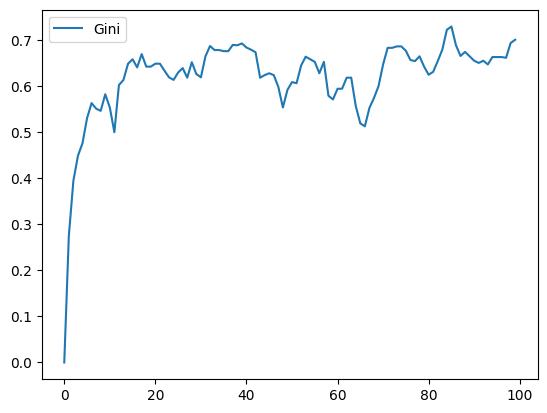

In [1]:
from mesa import Agent, Model
from mesa.datacollection import DataCollector
from mesa.time import SimultaneousActivation
from mesa.space import MultiGrid

class CellAgent(Agent):
    """ An agent with fixed initial energy."""
    def __init__(self, unique_id, model): 
        super().__init__(unique_id, model) 
        self.energy = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(self.pos,moore=True, include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
    
    def give_energy(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos]) 
        if len(cellmates) > 1:
                other = self.random.choice(cellmates)
                other.energy += 1
                self.energy -= 1

    def step(self): 
        self.move()
        #je donne de l'énergie si j'en ai
        if self.energy > 0: 
            self.give_energy()
    

def compute_gini(m):
        agent_energy = [agent.energy for agent in m.schedule.agents] 
        x = sorted(agent_energy)
        N = model.num_agents
        B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x)) 
        return (1 + (1/N) - 2*B)
    
class CellModel(Model):
    
    """A model with some number of agents.""" 
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True) 
        self.schedule = SimultaneousActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = CellAgent(i, self) 
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width) 
            y = self.random.randrange(self.grid.height) 
            self.grid.place_agent(a, (x, y))
        
        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Energy": "energy"}) # "Energy": lambda a: a.energy
    

    def step(self): 
        self.datacollector.collect(self) 
        self.schedule.step()


model = CellModel(50, 10, 10)

for i in range(100):
    model.step()

gini_model = model.datacollector.get_model_vars_dataframe()
#print(gini_model)
gini_model.plot()
#gini_agent = model.datacollector.get_agent_vars_dataframe()
#gini_agent.plot()
#print(gini_agent)


**<span style="color:red">
EXERCICE
</span>**

# Système multi-agent pour simuler le phénomoène de propagation d’une épidémie

La prévision de l'issue des épidémies de maladies infectieuses fait désormais l'objet d'une grande attention en raison de la pandémie COVID-19. 
Un cadre traditionnel pour la propagation des maladies infectieuses est le modèle dit SIR, qui divise une population en trois catégories : sensible (S), infectieuse (I) et rétablie/retirée (R). 
Ceux-ci peuvent être estimés dans le temps à l'aide d'un ensemble d'équations différentielles, compte tenu des taux de transition connus entre les États. Ces états dépendent de paramètres tels que le Ratio 0 noté par R0 de l'infection. En épidémiologie, le R0 correspond au nombre moyen attendu de cas directement générés par un cas dans une population où tous les individus sont sensibles à l'infection.
\
Ces méthodes basées sur des équations sont appelées modèles compartimentaux. 
Les modèles basés sur les agents sont une avancée plus récente qui simule de nombreux "agents" individuels dans la population pour atteindre le même objectif. Les agents sont hétérogènes, avec de multiples attributs et la complexité émerge du comportement global de nombreux agents combinés.
Le but de ce TD est de construire un modèle SIR en se basant sur l’approche multi-agent afin d’observer la propogation d’une épidémie à partir d’un ensemble de paramètres. Un agent représentera l’individu qui peut être Sensible, Infecté ou Rétabli. Pour cette première version et afin de simplifier l’exercice, l’agent individu se déplacera dans un espace quadrillé basique (grille). Nous utiliserons la bibliothèque Mesa Python pour développer le Système multi-agent (SMA) et illustrerons également les façons de visualiser graphiquement la simulation.
Création d’un modèle simple
L'idée principale avec Mesa est de créer deux classes, une pour le modèle et l'autre pour les agents. L'agent gère le comportement de l'individu simulé, par exemple comment il peut infecter d'autres voisins dans une grille ou un réseau. Le modèle contient tous les paramètres généraux et une grille pour les agents en mouvement qu’il crée et suit. La grille est une classe mesa.space.MultiGrid, qui permet à plusieurs agents d'occuper la même cellule. Un agent est une mesa.Agent qui comporte trois états possibles et des transitions entre eux au cours de la simulation. À chaque étape, l'agent se déplacera et pourra alors effectuer toute opération telle que l'infection d'un autre agent dans la même cellule de la grille si l'autre agent est susceptible. L'agent peut également se rétablir au fil du temps.
Nous créons d'abord une classe Model (qu’on nomme InfectionModel) qui définit une grille et un planificateur pour gérer les agents activés. Les périodes de temps sont représentées sous forme d'étapes (ticks) et les agents peuvent tous se déplacer une fois pendant chaque « tick ». Dans ce modèle, l'agent se déplace donc d’un pas à chaque étape, d’une manière aléatoire dans la grille et décide s'il peut infecter un autre agent qui se retrouve dans la même cellule que lui. La classe DataCollector permet de suivre les informations relatives aux agents tout au long de la simulation.

Soit la classe :

In [ ]:
from enum import IntEnum

class State(IntEnum):
    SUSCEPTIBLE = 0 #susceptible d'être infecté
    INFECTED = 1 #infecté
    REMOVED = 2 #immunisé

Commencez par créer un agent myAgent représentnant un individu. Cet agent a :
* un attribut _age_ initialisé par le constructeur à self.random.normalvariate(20,40)
* un attribut _state_ initialisé par le constructeur à State.SUSCEPTIBLE
* un attribut infection_time initialisé par le constructeur à 0.

**<span style="color:red">
SOLUTION
</span>**

2. La fonction step de cet agent est définie comme suit :
* l'agent vérifie son état
* l'agent se déplace
* l'agent entre en contact avec d'autres agents

In [ ]:
def step(self):
        self.status()
        self.move()
        self.contact()

3. La fonction _**status**_

Si l'agent est infecté (state égal à State.INFECTED), alors l'agent peut décéder. La probalibilité de décès **death_rate** est un paramètre du modèle dans lequel se situe l'agent. Vous pouvez utiliser par exemple (voir API bibliothèque numpy): numpy.random.choice([0,1], p=[death_rate,1-death_rate]) pour avoir une valeur au hasard entre 0 et 1 selon des probabilités de tirage.

* Si __**0**__ est tiré alors l'agent décède. Dans ce cas, il faut le retirer du système.

* Sinon il faut vérifier si le temps nécessaire pour le rétablissement de l'agent infecté est écoulé:
  * Un agent a un attribut __infection_time__ initialisé au temps système dès que ce dernier est infecté par un autre agent infecté. Cet attribut est initialisé au niveau de la fonction _contact_ que vous allez définir plus loin.
  * Un agent a aussi un attribut __recovery_time__ initialisé dès que ce dernier est infecté par un autre agent infecté. Cet attribut est également initialisé au niveau de la fonction _contact_ que vous allez définir plus loin.
  * donc si la différence entre l'instant système en cours et __infection_time__ de l'agent dépasse son __recovery_time__ , alors l'agent devient immunisé.

**<span style="color:red">
SOLUTION
</span>**

4. La fonction _**contact**_

La transmission se fait selon une probabilité fixée au niveau du modèle qui a un attribut _ptrans_ correspondanr à la probabilité qu’un agent transmette la maladie. Par exemple : 0,5, c’est à dire, lorsqu’un agent est infecté, il y a 50 % de chance qu’il transmette sa maladie aux autres agents qui sont dans la même position que lui.

L'agent vérifie d'abord s'il y a d'autres agents avec lui dans la même cellule. Vous pouvez par exemple utiliser la fonction self.model.grid.get_cell_list_contents([self.pos]) qui revoie la liste des agents dans une liste de cellules en lui donnant une liste composée uniquement de la position actuelle de l'agent.

Un agent, s'il est infecté, il peut infecter les autres agents qui sont dans la même position que lui. Il parcourt donc la liste des agents qui sont à la même position que lui.

A chaque fois, l'agent tire une valeur au hasard entre 0 et 1, si cette valeur est supérieure à _ptrans_ rien ne se passe, sinon l'autre agent est infecté (s'il ne l'est pas encore). Dans ce cas:
* __infection_time__ de l'agent infecté est initialisé au temps système
* __recovery_time__ de l'agent infecté est initialisé self.model.get_recovery_time() il s'agit d'une fonction qui sera définie au niveau du système permettant d'attriburer une durée de rétablissement à chaque agent infecté.

**<span style="color:red">
SOLUTION
</span>**

4. La fonction _**move**_

L'agent se déplace au hasard de sa position actuelle à une cellule voisine.

**<span style="color:red">
SOLUTION
</span>**

5. Créez le système InfectionModel.

* Le constructeur construit un système avec les arguments suivants :
     * N : Nombre d’agents par défaut 10
     * width et height : Tailles de la grille (largeur x hauteur) par défaut 10x10
     * ptrans : Probabilité qu’un agent transmette la maladie. Par défaut 0,5, c’est à dire, lorsqu’un agent est infecté, il y a 50 % de chance qu’il transmette sa maladie aux autres agents aux alentours.
     * death_rate : Probablité de décès d’un agent infecté (par défaut 2%).
     * recovery_days et recovery_sd : Le nombre de jours de rétablissement pour un agent est calcué en se basant sur une distribution normale de moyenne recovery_days et d’écart type recovery_sd.

* La grille est de type MultiGrid
* Le système permet une exécution quasi-simultanée des agents
* on ajoute un datacollector pour collecter à chaque étape, la valeur de l'état de chaque agent du système. L'objectif est d'étudier l'évolution des cas suceptibles, infectés et immunisés en fonction du temps.
* le constructeur crée et ajoute les  agents et les place au hasard dans la grille,
* Certains agents représenteront les premiers cas infectés. Donc à sa création, un agent a 2% de chance d'être infecté. S'il l'est, pensez à lui changer son état et à lui attribuer à son attribut __recovery_time__ la valeur de model.get_recovery_time() 

Il s'agit d'une fonction que vous pouvez définir dans le modèle InfectionModel comme suit : 

In [ ]:
def get_recovery_time(self):
        return int(self.random.normalvariate(self.recovery_days,self.recovery_sd))

cette fonction permet d'attribuer une durée de rétablisseent à un agent, de moyenne recovery_days et d'écrat type recovery_sd.

In [ ]:
from mesa import Agent, Model
from enum import IntEnum
import numpy
from mesa.time import SimultaneousActivation

class State(IntEnum):
    SUSCEPTIBLE = 0 #susceptible d'être infecté
    INFECTED = 1 #infecté
    REMOVED = 2 #immunisé
    
class myAgent(Agent):
    
    #Le constructeur
    def __init__(self, unique_id, model): 
        super().__init__(unique_id, model)
        #attribution aléatoire de l'age selon la loi normale de moyenne 20 et d'écart-type 40
        self.age = self.random.normalvariate(20,40)
        self.state=State.SUSCEPTIBLE
        self.infection_time=0
    
    #La fonction principale
    def step(self):
        self.status()
        self.move()
        self.contact()
    
    #La fonction pour vérifier l'état de l'agent (si infecté)
    def status(self):
        if self.state == State.INFECTED:
            death_rate=self.model.death_rate
            alive=numpy.random.choice([0,1], p=[death_rate,1-death_rate])
            if alive==0:
                self.model.scheduler.remove(self)
            if self.infection_time+self.recovery_time<=self.model.schedule.time:
                self.state=State.REMOVED
    
    def contact(self):
        if self.state==State.INFECTED:
            list_agents=self.model.grid.get_cell_list_contents([self.pos])
            if len(list_agents)>1:
                for a in list_agents:
                    if a.state==State.SUSCEPTIBLE and self.random.random()<=self.model.ptrans :
                        a.state=State.INFECTED
                        a.infection_time=self.model.schedule.time
                        a.recovery_time=self.model.get_recovery_time()
    def move(self):
        possible_steps = self.model.grid.get_neighborhood(self.pos,moore=True, include_center=True)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
        
class InfectionModel(Model):
    def __init__(self, N=10, width=10, height=10,ptrans=0.5,death_rate=0.02,recovery_days=7,recovery_sd=21):
        self.N = N
        self.width=width
        self.height=height
        self.ptrans=ptrans
        self.death_rate=death_rate
        self.recovery_days=recovery_days
        self.recovery_sd=recovery_sd
        self.grid = MultiGrid(width, height, True) 
        self.schedule = SimultaneousActivation(self)

        self.datacollector = DataCollector(agent_reporters={"State": "state"}) # "Energy": lambda a: a.energy

        #Création des agents en infectant 2% de ces agents crées et rattachés au système
        for i in range(self.num_agents):
            a = MyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width) 
            y = self.random.randrange(self.grid.height) 
            self.grid.place_agent(a, (x, y))
            infect=numpy.random.choice([0,1], p=[0.98,0.02])
            if infected==1:
                a.state=State.INFECTED
                a.recovery_time=self.model.get_recovery_time()
    
    def get_recovery_time(self):
        return int(self.random.normalvariate(self.recovery_days,self.recovery_sd))
        

6. la fonction principale du modèle

* A chaque étape (instant t), le système collecte les données avec le DataCollector avant de passer à l'instant t+1
* Affichez un aperçu des données collectées

In [ ]:
from mesa import Agent, Model
from enum import IntEnum
import numpy
from mesa.time import SimultaneousActivation

class State(IntEnum):
    SUSCEPTIBLE = 0 #susceptible d'être infecté
    INFECTED = 1 #infecté
    REMOVED = 2 #immunisé
    
class MyAgent(Agent):
    
    #Le constructeur
    def __init__(self, unique_id, model): 
        super().__init__(unique_id, model)
        #attribution aléatoire de l'age selon la loi normale de moyenne 20 et d'écart-type 40
        self.age = self.random.normalvariate(20,40)
        self.state=State.SUSCEPTIBLE
        self.infection_time=0
    
    #La fonction principale
    def step(self):
        self.status()
        self.move()
        self.contact()
    
    #La fonction pour vérifier l'état de l'agent (si infecté)
    def status(self):
        if self.state == State.INFECTED:
            death_rate=self.model.death_rate
            alive=numpy.random.choice([0,1], p=[death_rate,1-death_rate])
            if alive==0:
                self.model.schedule.remove(self)
            if self.infection_time+self.recovery_time<=self.model.schedule.time:
                self.state=State.REMOVED
    
    def contact(self):
        if self.state==State.INFECTED:
            list_agents=self.model.grid.get_cell_list_contents([self.pos])
            if len(list_agents)>1:
                for a in list_agents:
                    if a.state==State.SUSCEPTIBLE and self.random.random()<=self.model.ptrans :
                        a.state=State.INFECTED
                        a.infection_time=self.model.schedule.time
                        a.recovery_time=self.model.get_recovery_time()
    def move(self):
        possible_steps = self.model.grid.get_neighborhood(self.pos,moore=True, include_center=True)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
        
class InfectionModel(Model):
    def __init__(self, N=100, width=10, height=10,ptrans=0.5,death_rate=0.02,recovery_days=7,recovery_sd=21):
        self.N = N
        self.width=width
        self.height=height
        self.ptrans=ptrans
        self.death_rate=death_rate
        self.recovery_days=recovery_days
        self.recovery_sd=recovery_sd
        self.grid = MultiGrid(width, height, True) 
        self.schedule = SimultaneousActivation(self)

        self.datacollector = DataCollector(agent_reporters={"State": "state"}) # "Energy": lambda a: a.energy

        #Création des agents en infectant 2% de ces agents crées et rattachés au système
        for i in range(self.N):
            a = MyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width) 
            y = self.random.randrange(self.grid.height) 
            self.grid.place_agent(a, (x, y))
            infect=numpy.random.choice([0,1], p=[0.98,0.02])
            if infect==1:
                a.state=State.INFECTED
                a.recovery_time=self.get_recovery_time()
    
    #La fonction principale du SMA
    def step(self): 
        self.datacollector.collect(self) 
        self.schedule.step()
        
    def get_recovery_time(self):
        return int(self.random.normalvariate(self.recovery_days,self.recovery_sd))

#Programme principal
#Création du SMA et son exécution nbSteps fois
sma=InfectionModel()
nbSteps=400
for i in range(nbSteps):
    sma.step()

#Récupération des données collectées
state_agent = sma.datacollector.get_agent_vars_dataframe()
print(state_agent)

7. L'objectif maintenant est de croiser les données de manière à avoir à chaque étape, le nombre des agents susceptibles, infectés et immunisés. Vous pouvez utiliser la fonction suivante pour croiser les données : 

In [ ]:
from mesa import Agent, Model
from enum import IntEnum
import numpy
from mesa.time import SimultaneousActivation
import pandas as pnd

class State(IntEnum):
    SUSCEPTIBLE = 0 #susceptible d'être infecté
    INFECTED = 1 #infecté
    REMOVED = 2 #immunisé
    
class MyAgent(Agent):
    
    #Le constructeur
    def __init__(self, unique_id, model): 
        super().__init__(unique_id, model)
        #attribution aléatoire de l'age selon la loi normale de moyenne 20 et d'écart-type 40
        self.age = self.random.normalvariate(20,40)
        self.state=State.SUSCEPTIBLE
        self.infection_time=0
    
    #La fonction principale
    def step(self):
        self.status()
        self.move()
        self.contact()
    
    #La fonction pour vérifier l'état de l'agent (si infecté)
    def status(self):
        if self.state == State.INFECTED:
            death_rate=self.model.death_rate
            alive=numpy.random.choice([0,1], p=[death_rate,1-death_rate])
            if alive==0:
                self.model.schedule.remove(self)
            if self.infection_time+self.recovery_time<=self.model.schedule.time:
                self.state=State.REMOVED
    
    def contact(self):
        if self.state==State.INFECTED:
            list_agents=self.model.grid.get_cell_list_contents([self.pos])
            if len(list_agents)>1:
                for a in list_agents:
                    if a.state==State.SUSCEPTIBLE and self.random.random()<=self.model.ptrans :
                        a.state=State.INFECTED
                        a.infection_time=self.model.schedule.time
                        a.recovery_time=self.model.get_recovery_time()
    def move(self):
        possible_steps = self.model.grid.get_neighborhood(self.pos,moore=True, include_center=True)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
        
class InfectionModel(Model):
    def __init__(self, N=100, width=10, height=10,ptrans=0.5,death_rate=0.02,recovery_days=7,recovery_sd=21):
        self.N = N
        self.width=width
        self.height=height
        self.ptrans=ptrans
        self.death_rate=death_rate
        self.recovery_days=recovery_days
        self.recovery_sd=recovery_sd
        self.grid = MultiGrid(width, height, True) 
        self.schedule = SimultaneousActivation(self)

        self.datacollector = DataCollector(agent_reporters={"State": "state"}) # "Energy": lambda a: a.energy

        #Création des agents en infectant 2% de ces agents crées et rattachés au système
        for i in range(self.N):
            a = MyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width) 
            y = self.random.randrange(self.grid.height) 
            self.grid.place_agent(a, (x, y))
            infect=numpy.random.choice([0,1], p=[0.98,0.02])
            if infect==1:
                a.state=State.INFECTED
                a.recovery_time=self.get_recovery_time()
    
    #La fonction principale du SMA
    def step(self): 
        self.datacollector.collect(self) 
        self.schedule.step()
        
    def get_recovery_time(self):
        return int(self.random.normalvariate(self.recovery_days,self.recovery_sd))


def get_column_data(model):
    """pivot the model dataframe to get states count at each step"""
    agent_state = model.datacollector.get_agent_vars_dataframe()
    X = pnd.pivot_table(agent_state.reset_index(),index='Step',columns='State',aggfunc=numpy.size,fill_value=0)    
    labels = ['Susceptible','Infected','Removed']
    X.columns = labels[:len(X.columns)]
    return X

#Programme principal
#Création du SMA et son exécution nbSteps fois
sma=InfectionModel()
nbSteps=400
for i in range(nbSteps):
    sma.step()

#Récupération des données collectées

print(get_column_data(sma))

Remarquez l'utilisation de la fonction _pivot_table_ de la bibiothèque _pandas_ qui retourne une DataFrame. Elle crée un tableau croisé dynamique qui calcule par étape le nombre d’agents pour chaque état.

Affichez un aperçu de la dataFrame résultat.

8. Nous allons mainetnant procéder par l'affichage graphique avec la bibliothèque Bokeh : http://bokeh.org

Soit le code suivant :
* La fonction **plot_states_bokeh** permet la création du 1er graphique comprenant 3 courbes représenant respectivement l'évolution du nombre d'agenrs par état.
* La fonction **plot_cells_bokeh** permet la représentation graphiquiquement de la grille et son contenu.

In [ ]:
import pandas as pnd
from bokeh.models import ColumnDataSource, Line, Legend
from bokeh.palettes import Category10
from bokeh.plotting import figure
from bokeh.io import push_notebook, output_notebook,output_file,show
from bokeh.models import HoverTool, LinearColorMapper

def plot_states_bokeh(model,title=''):
    """Plot cases per country"""

    X = get_column_data(model)
    X = X.reset_index()
    source = ColumnDataSource(X)
    i=0
    colors = Category10[3]
    items=[]
    p = figure(width=600,height=400,tools=[],title=title,x_range=(0,100))        
    for c in X.columns[1:]:
        line = Line(x='Step',y=c, line_color=colors[i],line_width=3,line_alpha=.8,name=c)
        glyph = p.add_glyph(source, line)
        i+=1
        items.append((c,[glyph]))

    p.xaxis.axis_label = 'Step'
    p.add_layout(Legend(location='center_right',   
                items=items))
    p.background_fill_color = "#e1e1ea"
    p.background_fill_alpha = 0.5
    p.legend.label_text_font_size = "10pt"
    p.title.text_font_size = "15pt"
    p.toolbar.logo = None
    p.sizing_mode = 'scale_height'    
    return p


def plot_cells_bokeh(model):

    agent_counts = np.zeros((model.grid.width, model.grid.height))
    w=model.grid.width
    df=grid_values(model)
    df = pd.DataFrame(df.stack(), columns=['value']).reset_index()    
    columns = ['value']
    x = [(i, "@%s" %i) for i in columns]    
    hover = HoverTool(
        tooltips=x, point_policy='follow_mouse')
    colors = Category10[3]
    mapper = LinearColorMapper(palette=colors, low=df.value.min(), high=df.value.max())
    p = figure(width=500,height=500, tools=[hover], x_range=(-1,w), y_range=(-1,w))
    p.rect(x="level_0", y="level_1", width=1, height=1,
       source=df,
       fill_color={'field':'value', 'transform': mapper},
       line_color='black')
    p.background_fill_color = "black"
    p.grid.grid_line_color = None    
    p.axis.axis_line_color = None
    p.toolbar.logo = None
    return p

def grid_values(model):
    """Get grid cell states"""

    agent_counts = np.zeros((model.grid.width, model.grid.height))
    w=model.grid.width
    df=pd.DataFrame(agent_counts)
    for cell in model.grid.coord_iter():
        agents, (x, y) = cell
        c=None
        for a in agents:
            c = a.state
        df.iloc[x,y] = c
    return df

* Utilisez les fonctions ci-dessus pour l'affichage graphique au fur et à mesure des étapes. le programme principal pourrait être comme suit: 

In [ ]:
steps=400
pop=400

output_notebook()

model = InfectionModel(pop, 20, 20, ptrans=0.25, death_rate=0.01)
for i in range(steps):
    model.step()
    p1=plot_states_bokeh(model,title='step=%s' %i)
    
    p2=plot_cells_bokeh(model) 
    
    show(p1)
    show(p2)

**<span style="color:red">
SOLUTION
</span>**